<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C6/C6.html"><img src="../data/C6_nav.png" width="100"  style="float:right;" alt="C6"></a>
<h1>Fourier Tempogram</h1> 
</div>

<br/>

<p>
Following Section 6.2.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we show in this notebook how to compute a tempogram using a variant of a short-time Fourier transform. A MATLAB implementation of this approach can be found in the  <a href="https://www.audiolabs-erlangen.de/resources/MIR/tempogramtoolbox">Tempogram Toolbox</a>.
    
<ul>
<li><span style="color:black">
Peter Grosche and Meinard Müller: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2011_GroscheMueller_TempogramToolbox_ISMIR-LateBreaking.pdf"><strong>Tempogram Toolbox: MATLAB implementations for tempo and pulse analysis of music recordings.</strong></a> Late-Breaking and Demo Session of the International Conference on Music Information Retrieval (ISMIR), Miami, USA, 2011. 
<br>
 <a href="https://www.audiolabs-erlangen.de/resources/MIR/tempogramtoolbox">Website of the Tempogram Toolbox.</a>    
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_GroscheM11_TempogramToolbox_ISMIR-lateBreaking.txt"> Bibtex </a>
</span></li>
</ul>        
</p> 

##  Definition

We assume that we are given a discrete-time [novelty function](../C6/C6S1_OnsetDetection.html) $\Delta:\mathbb{Z}\to\mathbb{R}$ in which peaks indicate note onset candidates. The idea of Fourier analysis is to detect local periodicities in novelty curve by comparing it with windowed sinusoids. A high correlation of a local section of $\Delta$ with a windowed sinusoid indicates a periodicity of the sinusoid's frequency (given a suitable phase). This correlation (along with the phase) can be computed using a short-time Fourier transform. To this end, we fix a window function $w:\mathbb{Z}\to\mathbb{R}$ of finite length centered at $n=0$ (e.g., a sampled Hann window). Then, for a frequency parameter $\omega\in\mathbb{R}_{\geq 0}$ and time parameter $n\in\mathbb{Z}$, the complex Fourier coefficient $\mathcal{F}(n,\omega)$ is defined by

\begin{equation}
  \mathcal{F}(n,\omega) := \sum_{m\in\mathbb{Z}} 
	\Delta(m)\overline{w}(m-n)\mathrm{exp}(-2\pi i\omega m).
\end{equation}

This definition is similar to a [discrete short time Fourier transform](../C2/C2_STFT-Basic.html) when using a hop size $H=1$. Converting frequency to tempo values, we define the (discrete) **Fourier tempogram** $\mathcal{T}^\mathrm{F}: \mathbb{Z} \times \Theta \to \mathbb{R}_{\geq 0}$ by

\begin{equation}
\label{eq:BeatTempo:TempoAna:RepFourier:tempogramF}
	\mathcal{T}^\mathrm{F}(n,\tau) := |\mathcal{F}(n,\tau/60)|.
\end{equation}

For practical applications, $\mathcal{T}^\mathrm{F}$ is computed only for a small number of tempo parameters. For example, one may choose the set $\Theta=[30:600]$ covering the (integer) musical tempi between $30$ and $600~\mathrm{BPM}$. The bounds are motivated by the assumption that only musical events showing a temporal separation between roughly $100~\mathrm{msec}$ ($600~\mathrm{BPM}$) and $2~\mathrm{sec}$ ($30~\mathrm{BPM}$) contribute to the perception of tempo. Depending on the respective application and the nature of the music recording, a window size corresponding to $4$ to $12~\mathrm{sec}$ of audio is a reasonable range. Furthermore the feature rate of the resulting tempogram may be adjusted by introducing a hop size parameter $H$.

## Tempo Resolution


Using a tempo set like $\Theta=[30:600]$ requires a spectral analysis of high resolution&mdash;in particular in the lower frequency range. As an example, assume that the input novelty function $\Delta$ has a feature sampling rate $F_\mathrm{s}^\Delta = 100~\mathrm{Hz}$ and that the length of the window $w$ is $N=1000$ (covering $10$ seconds of the novelty function $\Delta$). Then, simply applying a DFT of size $N$, would yield Fourier coefficients corresponding to the [physical frequencies](../C2/C2_STFT-Basic.html)

\begin{equation}
         \omega = F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}^\Delta}{N} = k\cdot 0.1 ~\mathrm{Hz}
\end{equation}

for $k\in[0:500]$, which corresponds to the tempi $\tau= k\cdot 6~\mathrm{BPM}$. In other words, the DFT would yield a tempo resolution of $6~\mathrm{BPM}$ with tempo estimates ranging from $\tau=0$ up to $\tau=3000~\mathrm{BPM}$. If one is interested in a particular tempo set like $\Theta=[30:600]$, only a small fraction of the Fourier coefficients ($k\in[5:100]$) are needed. Furthermore, the tempo resolution of $6~\mathrm{BPM}$ is not sufficient. Therefore, a [straightforward STFT based on the DFT](../C2/C2_STFT-Basic.html) (see Section 2.1.4 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>) may not be suitable. One alternative is to compute the required Fourier coefficients individually (without using the DFT). Even though this cannot be done via the [FFT algorithm](../C2/C2_DFT-FFT.html), the computational complexity may still be reasonable since only a relatively small number of Fourier coefficients (corresponding to the tempo set $\Theta$) need to be computed. This is the strategy we follow in the remainder of this notebook.

## Implementation

In the following, we provide an implementation that is close to the formula

\begin{equation}
  \mathcal{F}(n,\omega) = \sum_{m\in\mathbb{Z}} \Delta(m)\overline{w}(m-n)\mathrm{exp}(-2\pi i \omega m).
\end{equation}

The novelty function $\Delta$ is assumed to have length $L\in\mathbb{N}$. As window function $w$, we choose a [Hann window](../C2/C2_STFT-Window.html) of length $N\in\mathbb{N}$, which is shifted by the hopsize $H\in\mathbb{N}$. Following the conventions of the FMP notebooks,  we use a [**centered view**](../C2/C2_STFT-Conventions.html), where the novelty function is zero-padded by half the window length. As a result, the first frame of $\mathcal{F}$ indexed by $n=0$ corresponds to the physical time position $t=0~\mathrm{sec}$. Note that the hopsize parameter $H$ reduces the frame rate of the tempogram to $F_\mathrm{s}^\Delta/H$. As input of our procedure, one may specify any finite set $\Theta$ containing tempo values. Our algorithm has an outer loop iterating over $\tau\in\Theta$. For each frequency $\omega=\tau/60$, the values $\mathcal{F}(n,\omega)$ are then computed in an inner loop iterating over the frame indices $n$. 

As an illustrating example, we use in the following a synthetic novelty function of $10$ seconds of duration. The curve consists of a click track, which has a tempo of $150~\mathrm{BPM}$ in its first half and a tempo of $120~\mathrm{BPM}$ in its second half.

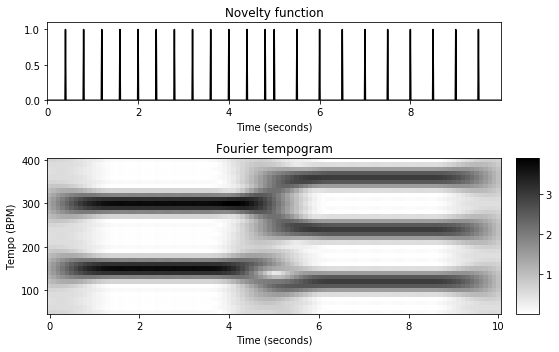

In [1]:
import os, sys
import numpy as np
import librosa
from scipy import signal
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as ipd
from numba import jit

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c6

%matplotlib inline


@jit(nopython=True)
def compute_tempogram_fourier(x, Fs, N, H, Theta=np.arange(30, 601, 1)):
    """Compute Fourier-based tempogram [FMP, Section 6.2.2]

    Notebook: C6/C6S2_TempogramFourier.ipynb

    Args:
        x (np.ndarray): Input signal
        Fs (scalar): Sampling rate
        N (int): Window length
        H (int): Hop size
        Theta (np.ndarray): Set of tempi (given in BPM) (Default value = np.arange(30, 601, 1))

    Returns:
        X (np.ndarray): Tempogram
        T_coef (np.ndarray): Time axis (seconds)
        F_coef_BPM (np.ndarray): Tempo axis (BPM)
    """
    win = np.hanning(N)
    N_left = N // 2
    L = x.shape[0]
    L_left = N_left
    L_right = N_left
    L_pad = L + L_left + L_right
    # x_pad = np.pad(x, (L_left, L_right), 'constant')  # doesn't work with jit
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    t_pad = np.arange(L_pad)
    M = int(np.floor(L_pad - N) / H) + 1
    K = len(Theta)
    X = np.zeros((K, M), dtype=np.complex_)

    for k in range(K):
        omega = (Theta[k] / 60) / Fs
        exponential = np.exp(-2 * np.pi * 1j * omega * t_pad)
        x_exp = x_pad * exponential
        for n in range(M):
            t_0 = n * H
            t_1 = t_0 + N
            X[k, n] = np.sum(win * x_exp[t_0:t_1])
        T_coef = np.arange(M) * H / Fs
        F_coef_BPM = Theta
    return X, T_coef, F_coef_BPM

Fs = 100
L = 10*Fs
x = np.zeros(L)
peaks = np.concatenate((np.arange(40,L//2,40),np.arange(500,L,50)))
x[peaks]=1

N = 300 #corresponding to 3 seconds (Fs = 100)
H = 10
Theta = np.arange(50,410,10)

X, T_coef, F_coef_BPM = compute_tempogram_fourier(x, Fs, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)
#tempogram = libfmp.c3.normalize_feature_sequence(tempogram, norm='max')

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [1, 2]}, figsize=(8, 5))        
libfmp.b.plot_signal(x, Fs, ax=ax[0,0], color='k', title='Novelty function')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], 
                     title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True);
plt.tight_layout()

## Interpretation 

The visualization of the Fourier tempogram $\mathcal{T}^\mathrm{F}$ reveals the dominant tempo over time. Indeed, there are high values for $\tau=150~\mathrm{BPM}$ in the first five seconds and high values for the tempo $\tau=120~\mathrm{BPM}$ the last five seconds. Being based on a Fourier analysis, an entry $\mathcal{T}^\mathrm{F}(n,\tau)$ is obtained by locally comparing the novelty function $\Delta$ in a neighborhood of $n$ with a windowed sinusoid that represents the tempo $\tau$ (or the frequency $\omega=\tau/60$). In the following code cell, this kind of analysis is illustrated for various time-tempo pairs indicated as red points in the tempogram visualization. We will discuss in the [FMP notebook on predominant local pulse estimation](../C6/C6S3_PredominantLocalPulse.html) on how to compute the windowed sinusoids using the [angle of the complex Fourier coefficient](../C2/C2_DFT-Phase.html).

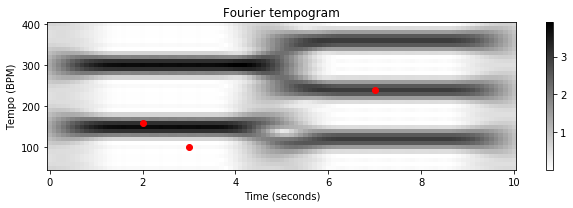

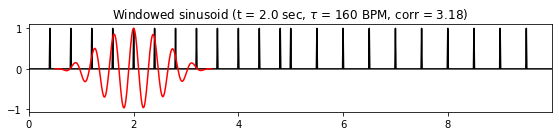

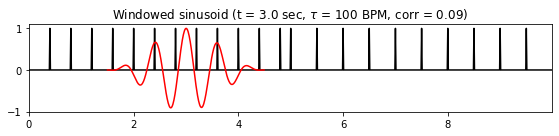

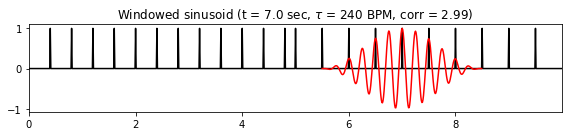

In [2]:
def compute_sinusoid_optimal(c, tempo, n, Fs, N, H):
    """Compute windowed sinusoid with optimal phase

    Notebook: C6/C6S2_TempogramFourier.ipynb

    Args:
        c (complex): Coefficient of tempogram (c=X(k,n))
        tempo (float): Tempo parameter corresponding to c (tempo=F_coef_BPM[k])
        n (int): Frame parameter of c
        Fs (scalar): Sampling rate
        N (int): Window length
        H (int): Hop size

    Returns:
        kernel (np.ndarray): Windowed sinusoid
        t_kernel (np.ndarray): Time axis (samples) of kernel
        t_kernel_sec (np.ndarray): Time axis (seconds) of kernel
    """
    win = np.hanning(N)
    N_left = N // 2
    omega = (tempo / 60) / Fs
    t_0 = n * H
    t_1 = t_0 + N
    phase = - np.angle(c) / (2 * np.pi)
    t_kernel = np.arange(t_0, t_1)
    kernel = win * np.cos(2 * np.pi * (t_kernel*omega - phase))
    t_kernel_sec = (t_kernel - N_left) / Fs
    return kernel, t_kernel, t_kernel_sec

def plot_signal_kernel(x, t_x, kernel, t_kernel, xlim=None, figsize=(8, 2), title=None):
    """Visualize signal and local kernel

    Notebook: C6/C6S2_TempogramFourier.ipynb

    Args:
        x: Signal
        t_x: Time axis of x (given in seconds)
        kernel: Local kernel
        t_kernel: Time axis of kernel (given in seconds)
        xlim: Limits for x-axis (Default value = None)
        figsize: Figure size (Default value = (8, 2))
        title: Title of figure (Default value = None)

    Returns:
        fig: Matplotlib figure handle
    """
    if xlim is None:
        xlim = [t_x[0], t_x[-1]]
    fig = plt.figure(figsize=figsize)
    plt.plot(t_x, x, 'k')
    plt.plot(t_kernel, kernel, 'r')
    plt.title(title)
    plt.xlim(xlim)
    plt.tight_layout()
    return fig

t_x = np.arange(x.shape[0])/Fs
coef_n = [20, 30, 70]
coef_k = [11, 5, 19]

fig, ax, im = libfmp.b.plot_matrix(tempogram, 
                T_coef=T_coef, F_coef=F_coef_BPM, figsize=(9,3),
                title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True);
ax[0].plot(T_coef[coef_n],F_coef_BPM[coef_k],'ro')

for i in range(len(coef_k)):
    k = coef_k[i]
    n = coef_n[i]
    tempo = F_coef_BPM[k]
    time = T_coef[n]
    corr = np.abs(X[k,n])
    kernel, t_kernel, t_kernel_sec = compute_sinusoid_optimal(X[k,n], 
                        F_coef_BPM[k], n, Fs, N, H)
    title=r'Windowed sinusoid (t = %0.1f sec, $\tau$ = %0.0f BPM, corr = %0.2f)'%(time, tempo, corr)
    fig = plot_signal_kernel(x, t_x, kernel, t_kernel_sec, title=title)
plt.tight_layout()

For the first time-tempo pair ($t=2~\mathrm{sec}$, $\tau=160~\mathrm{BPM}$), the positive parts of the windowed sinusoid nicely align with the impulse-like peaks of the novelty function $\Delta$, whereas the negative parts of the sinusoid fall into the zero-regions of $\Delta$. As a result, there is a high correlation between the windowed sinusoid 
and $\Delta$, which leads to a large coefficient $\mathcal{T}^\mathrm{F}(n,\tau)$. 

For the second pair ($t=3$, $\tau=100$), the sinusoid leads to a small coefficient. In this case, some peaks of $\Delta$ fall into positive parts of the sinusoid, whereas other peaks fall into the negative parts of the sinusoid. Because of the resulting cancellations, the overall correlation between $\Delta$ and the sinusoid is small. 

Finally, the third pair ($t=7$, $\tau=240$) illustrates that one obtains a high correlation when using a sinusoid that represents twice the main tempo. In this case, the peaks of $\Delta$ are aligned with every second positive part of the sinusoid, whereas all other parts of the sinusoid fall into the zero-regions of $\Delta$. This discussion shows that a Fourier tempogram generally indicates **tempo harmonics**, but suppresses **tempo subharmonics**, see also the [FMP notebook on tempo and beat](../C6/C6S2_TempoBeat.html).

## Example: Shostakovich

In the following example, we consider an excerpt of a recording of the Waltz No. 2 by Dimitri Shostakovich's Suite for Variety Orchestra No. 1. The score shows a piano-reduced version of the excerpt. 

<img src="../data/C6/FMP_C6_F07_Shostakovich_Waltz-02-Section_Score.png" width="400px" align="left" alt="FMP_C6_F07_Shostakovich_Waltz-02-Section_Score.png">

<br clear="all" />

<audio src="../data/C6/FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.mp3" type="audio/mpeg" controls="controls"></audio>

We start with a [spectral-based novelty function](../C6/C6S1_NoveltySpectral.html) resampled to $F_\mathrm{s}^\Delta = 100~\mathrm{Hz}$. Furthermore, we use a window size corresponding to $5$ seconds ($N=500$) and a tempo set $\Theta=[30:600]$ having a resolution of $1~\mathrm{BPM}$.  Using a hopsize parameter $H=10$, the feature rate of the resulting tempogram will be $10~\mathrm{Hz}$.

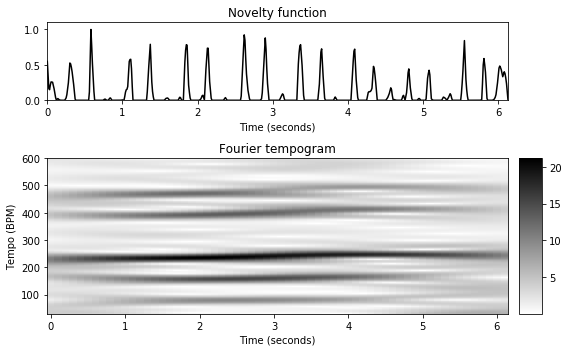

In [3]:
#fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F11_ClickTrack-BPM170-200.wav')
fn_wav = os.path.join('..', 'data', 'C6', 'FMP_C6_F07_Shostakovich_Waltz-02-Section_IncreasingTempo.wav')
Fs = 22050
x, Fs = librosa.load(fn_wav, Fs) 

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 500 #corresponding to 5 seconds (Fs_nov = 100)
H = 10
Theta = np.arange(30, 601)
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [1, 2]}, figsize=(8,5))        
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Novelty function')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], 
                     title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True);
plt.tight_layout()

As the Fourier tempogram $\mathcal{T}^\mathrm{F}$ reveals, the dominant tempo of this excerpt is between $200$ and $300~\mathrm{BPM}$. Starting with roughly $\tau=225~\mathrm{BPM}$, the tempo slightly increases over time. Interestingly, because of the weak downbeats every third beat within the 3/4 meter, the tempogram $\mathcal{T}^\mathrm{F}$ also shows some larger coefficients that correspond to $1/3$ and $2/3$ of the main tempo.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>